## Cost-Benefit Matrix

In [34]:
#Define profits
profit = .13*(np.mean(data['AVRG'])) #13% because profit margin of clothing stores
profit

14.805583693652594

In [35]:
# Assume cost is 1 (price of postage)
TN = 0
TP = -13.8
FP = 1
FN = 14.8

In [36]:
#Build cost-benefit matrix and calculate decision threshold tau
benefit_cost=np.matrix([[TN, FP],[FN, TP]])
benefit_cost
tau = (FP - TN)/(FP + FN -TP - TN)
tau

0.03378378378378378

In [37]:
#If we send mail to all the customers.
y_pred_all=np.ones((len(test), 1))
y_pred_no=np.zeros((len(test), 1))
print(len(y_pred_all))

4348


In [38]:
#Build benchmark model table
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score
columns=['TN(0)', 'TP(-13.8)', 'FN(14.8)', 'FP(1)', 'Error rate', 'Total cost per customer']
rows=['Send to all customers', 'Do not send to any customer']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

Confusion_all=confusion_matrix(test[response], y_pred_all)
error_rate_all =  1 - accuracy_score(test[response], y_pred_all)
formula1=Confusion_all[0,0]*benefit_cost[0,0]+Confusion_all[0,1]*benefit_cost[0,1]+Confusion_all[1,0]*benefit_cost[1,0]+Confusion_all[1,1]*benefit_cost[1,1]
results.iloc[0,0]=  Confusion_all[0,0]
results.iloc[0,1]=  Confusion_all[1,1]
results.iloc[0,2]=  Confusion_all[1,0]
results.iloc[0,3]=  Confusion_all[0,1]
results.iloc[0,4]=  error_rate_all
results.iloc[0,5]=  (formula1/len(test[response])).round(2)

Confusion_no=confusion_matrix(test[response], y_pred_no)
error_rate_no =  1 - accuracy_score(test[response], y_pred_no)
formula2=Confusion_no[0,0]*benefit_cost[0,0]+Confusion_no[0,1]*benefit_cost[0,1]+Confusion_no[1,0]*benefit_cost[1,0]+Confusion_no[1,1]*benefit_cost[1,1]
results.iloc[1,0]=  Confusion_no[0,0]
results.iloc[1,1]=  Confusion_no[1,1]
results.iloc[1,2]=  Confusion_no[1,0]
results.iloc[1,3]=  Confusion_no[0,1]
results.iloc[1,4]=  error_rate_no
results.iloc[1,5]=  (formula2/len(test[response])).round(2)


results.round(3)

,TN(0),TP(-13.8),FN(14.8),FP(1),Error rate,Total cost per customer
Send to all customers,0.0,731.0,0.0,3617.0,0.832,-1.49
Do not send to any customer,3617.0,0.0,731.0,0.0,0.168,2.49


## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression
logit = LogisticRegression()
logit.fit(train[predictors], train[response])

# L-1 Regularised logistic regression
logit1_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring = 'neg_log_loss')
logit1_l1.fit(train[predictors], train[response])

# L-2 Regularised logistic regression
logit1_l2 = LogisticRegressionCV(penalty='l2', scoring = 'neg_log_loss')
logit1_l2.fit(train[predictors], train[response])

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

In [40]:
Pred1=['MON','TOMONSPEND','OMONSPEND','STMONSPEND','PREVPD']
for i in Pred1:
    glm = sm.Logit(train[response], sm.add_constant(train[i])).fit()
    #print(glm.summary())
    
Pred2=['PROMOS','MAILED','RESPONDED','RESPONSERATE']
for i in Pred2:
    glm = sm.Logit(train[response], sm.add_constant(train[i])).fit()
    #print(glm.summary())

Pred3=['CLASSES','HI','FREDAYS','LTFREDAY']
for i in Pred3:
    glm = sm.Logit(train[response], sm.add_constant(train[i])).fit()
    #print(glm.summary())

Optimization terminated successfully.
         Current function value: 0.392172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388114
  

## Discriminant Analysis

In [41]:
#Remove binary variables for discriminant analysis
gda_preds = predictors.copy()
gda_preds.remove('CC_CARD')
gda_preds.remove('WEB')
gda_preds.remove('VALPHON')

In [42]:
#Fit LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(train[gda_preds], train[response])

qda = QuadraticDiscriminantAnalysis()
qda.fit(train[gda_preds], train[response])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [43]:
#Cross validation for regularized QDA
from sklearn.model_selection import cross_val_score

def qda_cv(X_train, y_train):
    
    alphas  = np.linspace(0, 1, 21)
    best_score = -np.inf
    
    for alpha in alphas:
        qda = QuadraticDiscriminantAnalysis(reg_param=alpha)
        score = np.mean(cross_val_score(qda, X_train, y_train, cv=10, scoring = 'accuracy'))
        if score >= best_score:
            best = qda
            best_score = score
    
    return qda.fit(X_train, y_train)
        
qda_reg = qda_cv(train[gda_preds], train[response]) 

## Neural Networks

In [44]:
%%time
#Build a basic neural network with one hidden layer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

np.random.seed(0)
nn = Sequential()
nn.add(Dense(25, input_dim = len(predictors), activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))

nn.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
nn.fit(np.array(train[predictors]), np.array(train[response]), epochs = 100, batch_size =  500)
nn.summary()

Using TensorFlow backend.


Epoch 1/100
13044/13044 [==============================] - 0s - loss: 0.6334 - acc: 0.6594     
Epoch 2/100
13044/13044 [==============================] - 0s - loss: 0.4554 - acc: 0.7973     
Epoch 3/100
13044/13044 [==============================] - 0s - loss: 0.3973 - acc: 0.8316     
Epoch 4/100
13044/13044 [==============================] - 0s - loss: 0.3745 - acc: 0.8454     
Epoch 5/100
13044/13044 [==============================] - 0s - loss: 0.3637 - acc: 0.8497     
Epoch 6/100
13044/13044 [==============================] - 0s - loss: 0.3567 - acc: 0.8511     
Epoch 7/100
13044/13044 [==============================] - 0s - loss: 0.3515 - acc: 0.8522     
Epoch 8/100
13044/13044 [==============================] - 0s - loss: 0.3474 - acc: 0.8539     
Epoch 9/100
13044/13044 [==============================] - 0s - loss: 0.3435 - acc: 0.8543     
Epoch 10/100
13044/13044 [==============================] - 0s - loss: 0.3409 - acc: 0.8557     
Epoch 11/100
13044/13044 [=============

## Random Forest

In [45]:
%%time
#Cross validation for a random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(0)

model = RandomForestClassifier(criterion = 'entropy', n_estimators = 120, random_state = 0)
tuning_params = {'min_samples_leaf':[1,5,10],
                 'max_features':np.arange(1,len(predictors)+1),}

rf = RandomizedSearchCV(model, tuning_params, cv = 5, return_train_score = False, n_jobs = 4, scoring = 'neg_log_loss')
rf.fit(train[predictors], train[response])
rf.best_params_

CPU times: user 6.85 s, sys: 177 ms, total: 7.02 s
Wall time: 3min 4s


In [46]:
rf.best_params_

{'max_features': 9, 'min_samples_leaf': 10}

In [47]:
#Feature importance for random forest
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 120, random_state = 0, min_samples_leaf = 10, max_features = 9)
rf.fit(train[predictors],train[response])
rf.feature_importances_

array([ 0.08526612,  0.05974159,  0.01576427,  0.04658457,  0.02851964,
        0.00942867,  0.31849963,  0.01234955,  0.03711391,  0.03611594,
        0.00431177,  0.0704613 ,  0.04273769,  0.02391378,  0.01595033,
        0.01159466,  0.02542825,  0.0582555 ,  0.01137625,  0.00128074,
        0.00566047,  0.00163928,  0.02943836,  0.02054666,  0.02802107])

## Naive Bayes

In [48]:
#Fit naive bayes model
from sklearn.naive_bayes import BernoulliNB

def nb_cv(X_train, y_train):
    
    alphas  = np.linspace(0, 1, 21)
    best_score = -np.inf
    
    for alpha in alphas:
        nbc = BernoulliNB(alpha=alpha)
        score = np.mean(cross_val_score(nbc, X_train, y_train, cv=10, scoring = 'neg_log_loss'))
        if score >= best_score:
            best = nbc
            best_score = score
    
    return nbc.fit(X_train, y_train)

nbc = nb_cv(train[predictors],train[response])

## Support Vector Machines

In [49]:
#Fit support vector machines model
from sklearn.svm import SVC
sv = SVC(class_weight = 'balanced', probability = True)
sv.fit(train[predictors],train[response])

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Model Fit on Validation Set for Selection

In [50]:
#Fit all models on validation set for selection except neural networks
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv, rf, nbc, logit, logit1_l1, logit1_l2, lda, qda, qda_reg]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(validate[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = (method.predict_proba(validate[predictors]))
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion  = confusion_matrix(validate[response], y_pred) 
    tn, fp, fn, tp = Confusion.ravel()
    error_rate =  1 - accuracy_score(validate[response], y_pred)
    formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(validate[response])).round(2)
    se = np.sqrt(error_rate*(1- error_rate)/len(validate[response]))
    
    results.iloc[i,0] = error_rate
    results.iloc[i,1] = se
    results.iloc[i,2] = Confusion[1,1]/float(np.sum(Confusion[1,:]))
    results.iloc[i,3] = Confusion[0,0]/float(np.sum(Confusion[0,:]))
    results.iloc[i,4] = fn/float(tp+fn)
    results.iloc[i,5] = roc_auc_score(validate[response], y_prob[:,1])
    results.iloc[i,6] = precision_score(validate[response], y_pred)
    results.iloc[i,7] = formula2
    results.iloc[i,8] = formula2 - se*stats.t.ppf(0.95, df = len(validate[response])-1)
    results.iloc[i,9] = formula2 + se*stats.t.ppf(0.95, df = len(validate[response])-1)

results.round(3)

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.543,0.008,0.986,0.351,0.014,0.847,0.232,-1.68,-1.692,-1.668
Random Forest,0.515,0.008,0.983,0.386,0.017,0.855,0.242,-1.70,-1.712,-1.688
Naive Bayes,0.298,0.007,0.758,0.691,0.242,0.797,0.328,-0.88,-0.891,-0.869
Logistic,0.530,0.008,0.989,0.367,0.011,0.857,0.237,-1.71,-1.722,-1.698
L1 regularised,0.532,0.008,0.989,0.364,0.011,0.857,0.237,-1.71,-1.722,-1.698
L2 regularised,0.530,0.008,0.989,0.366,0.011,0.857,0.237,-1.71,-1.722,-1.698
LDA,0.519,0.008,0.986,0.380,0.014,0.857,0.241,-1.71,-1.722,-1.698
QDA,0.239,0.006,0.665,0.780,0.335,0.819,0.376,-0.52,-0.531,-0.509
Regularised QDA,0.267,0.007,0.694,0.741,0.306,0.801,0.348,-0.62,-0.631,-0.609


#### Model Fit Neural Network on Validation Set for Selection

In [51]:
#Fit all models for selection neural network model on validation set
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bount 95% CI', 'Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn = (nn.predict_proba(np.array(validate[predictors])))
y_pred_nn = np.array(((pd.DataFrame(y_prob_nn)) > tau).astype(int))

Confusion  = confusion_matrix(validate[response], y_pred_nn) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(validate[response], y_pred_nn)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(validate[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(validate[response]))

results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(validate[response], y_prob_nn)
results.iloc[0,6]=  precision_score(validate[response], y_pred_nn)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(validate[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(validate[response])-1)

results.round(3)

3136/4348 [====================>.........] - ETA: 0s

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bount 95% CI,Upper Bound 95% CI
Neural Networks,0.466,0.008,0.976,0.446,0.024,0.857,0.26,-1.72,-1.732,-1.708


## Model Evaluation on Test Data

0 SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Normalized confusion matrix


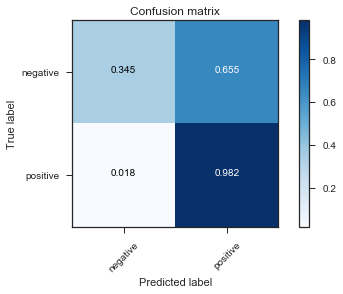

1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Normalized confusion matrix


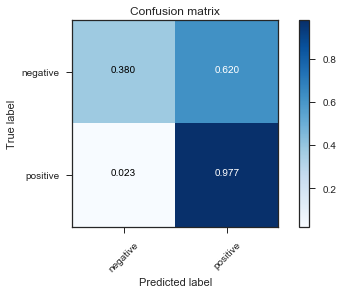

2 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Normalized confusion matrix


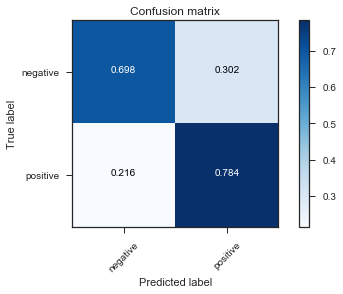

3 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Normalized confusion matrix


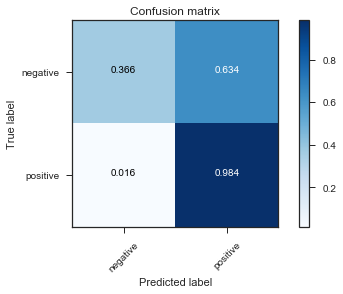

4 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='neg_log_loss', solver='liblinear',
           tol=0.0001, verbose=0)
Normalized confusion matrix


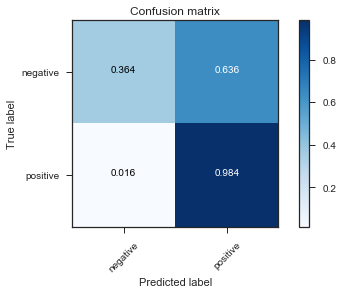

5 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)
Normalized confusion matrix


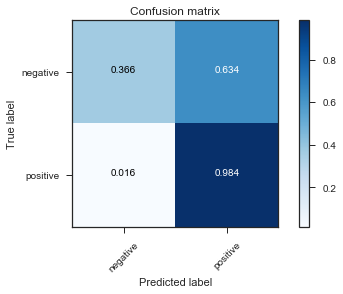

6 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
Normalized confusion matrix


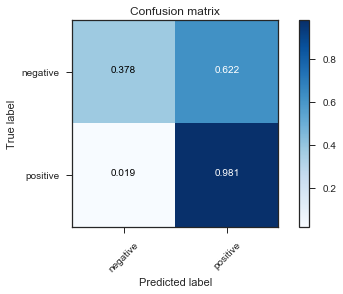

7 QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
Normalized confusion matrix


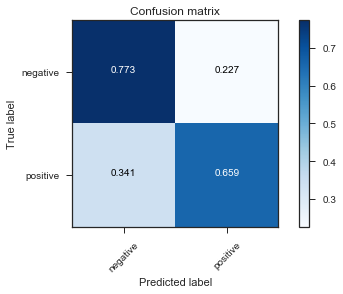

8 QuadraticDiscriminantAnalysis(priors=None, reg_param=1.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
Normalized confusion matrix


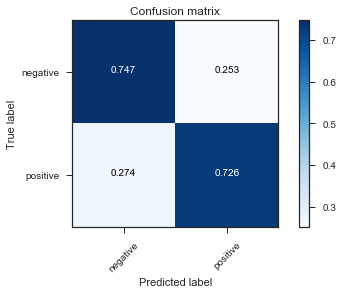

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.548,0.008,0.982,0.345,0.018,0.835,0.233,-1.69,-1.702,-1.678
Random Forest,0.519,0.008,0.977,0.380,0.023,0.840,0.242,-1.69,-1.702,-1.678
Naive Bayes,0.288,0.007,0.784,0.698,0.216,0.796,0.344,-1.03,-1.041,-1.019
Logistic,0.530,0.008,0.984,0.366,0.016,0.844,0.239,-1.71,-1.722,-1.698
L1 regularised,0.532,0.008,0.984,0.364,0.016,0.844,0.238,-1.71,-1.722,-1.698
L2 regularised,0.530,0.008,0.984,0.366,0.016,0.844,0.239,-1.71,-1.722,-1.698
LDA,0.520,0.008,0.981,0.378,0.019,0.839,0.242,-1.71,-1.722,-1.698
QDA,0.246,0.007,0.659,0.773,0.341,0.807,0.370,-0.49,-0.501,-0.479
Regularised QDA,0.256,0.007,0.726,0.747,0.274,0.798,0.367,-0.79,-0.801,-0.779


In [52]:
#Evaluate all models except neural networks on test data
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score
from statlearning import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost', 'Lower Bound 95% CI', 'Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv, rf, nbc, logit, logit1_l1, logit1_l2, lda, qda, qda_reg]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(test[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = (method.predict_proba(test[predictors]))
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion  = confusion_matrix(test[response], y_pred) 
    tn, fp, fn, tp = Confusion.ravel()
    error_rate =  1 - accuracy_score(test[response], y_pred)
    formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
    se = np.sqrt(error_rate*(1- error_rate)/len(test[response]))
    
    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  se
    results.iloc[i,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
    results.iloc[i,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
    results.iloc[i,4]=  fn/float(tp+fn)
    results.iloc[i,5]=  roc_auc_score(test[response], y_prob[:,1])
    results.iloc[i,6]=  precision_score(test[response], y_pred)
    results.iloc[i,7]=  formula2
    results.iloc[i,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
    results.iloc[i,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)
    
    print(i,method)
    plot_confusion_matrix(Confusion, classes=['negative','positive'], normalize=True)
    plt.show()

results.round(3)

#### Model Evaluation Neural Network on Test Data

3520/4348 [=======================>......] - ETA: 0sNormalized confusion matrix


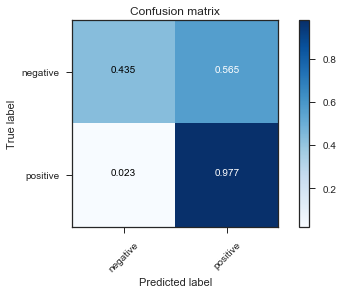

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Neural Networks,0.474,0.008,0.977,0.435,0.023,0.848,0.259,-1.74,-1.752,-1.728


In [53]:
#Evaluate all models on test data for 
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost', 'Lower Bound 95% CI', 'Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn = (nn.predict_proba(np.array(test[predictors])))
y_pred_nn = np.array(((pd.DataFrame(y_prob_nn)) > tau).astype(int))

Confusion  = confusion_matrix(test[response], y_pred_nn) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(test[response], y_pred_nn)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(test[response])) 
    
results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(test[response], y_prob_nn)
results.iloc[0,6]=  precision_score(test[response], y_pred_nn)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

plot_confusion_matrix(Confusion, classes=['negative','positive'], normalize=True)
plt.show()

results.round(3)

# Balanced Data 50%-50% ratio (After Standardization and Original Results)

In [54]:
#SMOTE function to oversample minority class to 50/50 ratio
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state = 1, ratio = 'minority')
train_res_preds, train_res_resp = os.fit_sample(train[predictors],train[response])

## Logistic Regression

In [55]:
# Logistic regression
logit_res = LogisticRegression()
logit_res.fit(train_res_preds, train_res_resp)

# L-1 Regularised logistic regression
logit1_l1_res = LogisticRegressionCV(penalty='l1', solver='liblinear')
logit1_l1_res.fit(train_res_preds, train_res_resp)

# L-2 Regularised logistic regression
logit1_l2_res = LogisticRegressionCV(penalty='l2')
logit1_l2_res.fit(train_res_preds, train_res_resp)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

## Discriminant Analysis

In [56]:
gda_preds_res = pd.DataFrame(train_res_preds)
del gda_preds_res[13]
del gda_preds_res[21]
del gda_preds_res[24]

In [57]:
lda_res = LinearDiscriminantAnalysis()
lda_res.fit(gda_preds_res, train_res_resp)

qda_res = QuadraticDiscriminantAnalysis()
qda_res.fit(gda_preds_res, train_res_resp)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [58]:
qda_reg_res = qda_cv(gda_preds_res, train_res_resp)

## Neural Networks

In [59]:
%%time
np.random.seed(0)
nn_res = Sequential()
nn_res.add(Dense(100, input_dim = len(predictors), activation = 'relu'))
nn_res.add(Dense(75, activation = 'relu'))
nn_res.add(Dense(50, activation = 'relu'))
nn_res.add(Dense(25, activation = 'relu'))
nn_res.add(Dense(1, activation = 'sigmoid'))

nn_res.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
nn_res.fit(np.array(train_res_preds), np.array(train_res_resp), epochs = 100, batch_size =  500)
nn_res.summary()

Epoch 1/100
21772/21772 [==============================] - 0s - loss: 0.5144 - acc: 0.7415     
Epoch 2/100
21772/21772 [==============================] - 0s - loss: 0.4553 - acc: 0.7801     
Epoch 3/100
21772/21772 [==============================] - 0s - loss: 0.4357 - acc: 0.7938     
Epoch 4/100
21772/21772 [==============================] - 0s - loss: 0.4222 - acc: 0.8014     
Epoch 5/100
21772/21772 [==============================] - 0s - loss: 0.4125 - acc: 0.8080     
Epoch 6/100
21772/21772 [==============================] - 0s - loss: 0.4036 - acc: 0.8124     
Epoch 7/100
21772/21772 [==============================] - 0s - loss: 0.3952 - acc: 0.8188     
Epoch 8/100
21772/21772 [==============================] - 0s - loss: 0.3895 - acc: 0.8212     
Epoch 9/100
21772/21772 [==============================] - 0s - loss: 0.3809 - acc: 0.8276     
Epoch 10/100
21772/21772 [==============================] - 0s - loss: 0.3740 - acc: 0.8306     
Epoch 11/100
21772/21772 [=============

## Random Forest

In [60]:
%%time
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)

model = RandomForestClassifier(criterion = 'entropy', n_estimators = 120, random_state = 0)
tuning_params = {'min_samples_leaf':[1,5,10],
                 'max_features':np.arange(1,len(predictors)+1),}

rf_res = RandomizedSearchCV(model, tuning_params, cv = 5, return_train_score = False, n_jobs = 4, scoring = 'neg_log_loss')
rf_res.fit(train_res_preds, train_res_resp)
rf_res.best_params_

CPU times: user 41.1 s, sys: 453 ms, total: 41.5 s
Wall time: 8min 35s


## Naive Bayes

In [61]:
from sklearn.naive_bayes import BernoulliNB
nbc_res = BernoulliNB()
nbc_res.fit(train_res_preds, train_res_resp)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

## Support Vector Machines

In [62]:
from sklearn.svm import SVC
sv_res = SVC(class_weight = 'balanced', probability = True)
sv_res.fit(train_res_preds, train_res_resp)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Model Fit on Validation Set for Selection 50/50 Balanced

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results_res=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv_res, rf_res, nbc_res, logit_res, logit1_l1_res, logit1_l2_res, lda_res, qda_res, qda_reg_res]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(validate[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = (method.predict_proba(validate[predictors]))
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion_res  = confusion_matrix(validate[response], y_pred) 
    tn_res, fp_res, fn_res, tp_res = Confusion_res.ravel()
    error_rate_res =  1 - accuracy_score(validate[response], y_pred)
    formula2_res=((tn_res*benefit_cost[0,0]+fp_res*benefit_cost[0,1]+fn_res*benefit_cost[1,0]+tp_res*benefit_cost[1,1])/len(validate[response])).round(2)
    se_res = np.sqrt(error_rate_res*(1- error_rate_res)/len(validate[response]))
    
    results_res.iloc[i,0]=  error_rate_res
    results_res.iloc[i,1]=  se_res
    results_res.iloc[i,2]=  Confusion_res[1,1]/float(np.sum(Confusion_res[1,:]))
    results_res.iloc[i,3]=  Confusion_res[0,0]/float(np.sum(Confusion_res[0,:]))
    results_res.iloc[i,4]=  fn_res/float(tp_res+fn_res)
    results_res.iloc[i,5]=  roc_auc_score(validate[response], y_prob[:,1])
    results_res.iloc[i,6]=  precision_score(validate[response], y_pred)
    results_res.iloc[i,7]=  formula2_res
    results_res.iloc[i,8] = formula2_res - se_res*stats.t.ppf(0.95, df = len(test[response])-1)
    results_res.iloc[i,9] = formula2_res + se_res*stats.t.ppf(0.95, df = len(test[response])-1)

results_res.round(3)


,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.585,0.007,0.989,0.301,0.011,0.835,0.220,-1.66,-1.672,-1.648
Random Forest,0.528,0.008,0.985,0.370,0.015,0.849,0.237,-1.69,-1.702,-1.678
Naive Bayes,0.321,0.007,0.798,0.656,0.202,0.798,0.316,-1.04,-1.052,-1.028
Logistic,0.730,0.007,1.000,0.125,0.000,0.855,0.185,-1.56,-1.571,-1.549
L1 regularised,0.731,0.007,1.000,0.123,0.000,0.855,0.185,-1.56,-1.571,-1.549
L2 regularised,0.729,0.007,1.000,0.125,0.000,0.855,0.185,-1.56,-1.571,-1.549
LDA,0.729,0.007,0.999,0.126,0.001,0.850,0.185,-1.56,-1.571,-1.549
QDA,0.257,0.007,0.636,0.765,0.364,0.775,0.350,-0.37,-0.381,-0.359
Regularised QDA,0.293,0.007,0.733,0.701,0.267,0.803,0.328,-0.77,-0.781,-0.759


#### Model Evaluation Neural Network on Validation Data balanced

In [64]:
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn = (nn_res.predict_proba(np.array(validate[predictors])))
y_pred_nn = np.array(((pd.DataFrame(y_prob_nn)) > tau).astype(int))

Confusion  = confusion_matrix(validate[response], y_pred_nn) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(validate[response], y_pred_nn)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(validate[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(validate[response]))
    
results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(validate[response], y_prob_nn)
results.iloc[0,6]=  precision_score(validate[response], y_pred_nn)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

2464/4348 [================>.............] - ETA: 0s

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Neural Networks,0.236,0.006,0.619,0.793,0.381,0.789,0.373,-0.31,-0.321,-0.299


## Model Evaluation on Test Data 50/50 Balanced

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv_res, rf_res, nbc_res, logit_res, logit1_l1_res, logit1_l2_res, lda_res, qda_res, qda_reg_res]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(test[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = method.predict_proba(test[predictors])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion  = confusion_matrix(test[response], y_pred) 
    tn, fp, fn, tp = Confusion.ravel()
    error_rate =  1 - accuracy_score(test[response], y_pred)
    formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
    se = np.sqrt(error_rate*(1- error_rate)/len(test[response]))
    
    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  se
    results.iloc[i,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
    results.iloc[i,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
    results.iloc[i,4]=  fn/float(tp+fn)
    results.iloc[i,5]=  roc_auc_score(test[response], y_prob[:,1])
    results.iloc[i,6]=  precision_score(test[response], y_pred)
    results.iloc[i,7]=  formula2
    results.iloc[i,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
    results.iloc[i,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.594,0.007,0.988,0.288,0.012,0.823,0.219,-1.67,-1.682,-1.658
Random Forest,0.526,0.008,0.984,0.371,0.016,0.828,0.240,-1.72,-1.732,-1.708
Naive Bayes,0.320,0.007,0.802,0.656,0.198,0.796,0.320,-1.08,-1.092,-1.068
Logistic,0.724,0.007,1.000,0.130,0.000,0.841,0.188,-1.60,-1.611,-1.589
L1 regularised,0.726,0.007,1.000,0.127,0.000,0.841,0.188,-1.59,-1.601,-1.579
L2 regularised,0.724,0.007,1.000,0.130,0.000,0.841,0.189,-1.60,-1.611,-1.589
LDA,0.721,0.007,1.000,0.134,0.000,0.831,0.189,-1.60,-1.611,-1.589
QDA,0.256,0.007,0.620,0.769,0.380,0.775,0.352,-0.30,-0.311,-0.289
Regularised QDA,0.282,0.007,0.762,0.709,0.238,0.800,0.346,-0.93,-0.941,-0.919


#### Model Evaluation on Test Data Neural Networks balanced

In [66]:
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn_res = (nn_res.predict_proba(np.array(test[predictors])))
y_pred_nn_res = np.array(((pd.DataFrame(y_prob_nn_res)) > tau).astype(int))

Confusion  = confusion_matrix(test[response], y_pred_nn_res) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(test[response], y_pred_nn_res)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(test[response]))

results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(test[response], y_prob_nn_res)
results.iloc[0,6]=  precision_score(test[response], y_pred_nn_res)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

2432/4348 [===============>..............] - ETA: 0s

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Neural Networks,0.248,0.007,0.585,0.786,0.415,0.768,0.356,-0.15,-0.161,-0.139


Oversampling the data to a 50/50 ratio does not seem to help the model. Possibly because the loss matrix is defined in such a way that a false negative is very costly compared to a false positive. We try again below with a 70/30 ratio

# Balanced Data 70%-30% ratio (After Standardization and Original Results)

We oversample the data now so 70% respond and 30% do not

In [67]:
from sklearn.utils import resample
len(train[train['RESP']==0])

10886

In [68]:
#Determine number to get 70/30 ratio
(10886/.3)-10886

25400.66666666667

In [69]:
# Separate majority and minority classes
train_majority = train[train['RESP']==0]
train_minority = train[train['RESP']==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=25400,    # oversample
                                 random_state=123) # reproducible results

    
# Combine majority class with upsampled minority class
train_resampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_resampled.RESP.value_counts()

1    25400
0    10886
Name: RESP, dtype: int64

## Logistic Regression

In [70]:
# Logistic regression
logit_res70 = LogisticRegression()
logit_res70.fit(train_resampled[predictors], train_resampled[response])

# L-1 Regularised logistic regression
logit1_l1res70 = LogisticRegressionCV(penalty='l1', solver='liblinear', scoring = 'neg_log_loss')
logit1_l1res70.fit(train_resampled[predictors], train_resampled[response])

# L-2 Regularised logistic regression
logit1_l2res70 = LogisticRegressionCV(penalty='l2', scoring = 'neg_log_loss')
logit1_l2res70.fit(train_resampled[predictors], train_resampled[response])

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

## Discriminant Analysis

In [71]:
#Fit LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda_res70 = LinearDiscriminantAnalysis()
lda_res70.fit(train_resampled[gda_preds], train_resampled[response])

qda_res70 = QuadraticDiscriminantAnalysis()
qda_res70.fit(train_resampled[gda_preds], train_resampled[response])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [72]:
qda_reg_res70 = qda_cv(train_resampled[gda_preds], train_resampled[response]) 

## Neural Networks

In [73]:
%%time
np.random.seed(0)
nn_res70 = Sequential()
nn_res70.add(Dense(25, input_dim = len(predictors), activation = 'relu'))
nn_res70.add(Dense(1, activation = 'sigmoid'))

nn_res70.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
nn_res70.fit(np.array(train_resampled[predictors]), np.array(train_resampled[response]), epochs = 100, batch_size =  500)
nn_res70.summary()

Epoch 1/100
36286/36286 [==============================] - 0s - loss: 0.6116 - acc: 0.6738     
Epoch 2/100
36286/36286 [==============================] - 0s - loss: 0.4673 - acc: 0.7820     
Epoch 3/100
36286/36286 [==============================] - 0s - loss: 0.4451 - acc: 0.7957     
Epoch 4/100
36286/36286 [==============================] - 0s - loss: 0.4304 - acc: 0.8045     
Epoch 5/100
36286/36286 [==============================] - 0s - loss: 0.4203 - acc: 0.8133     
Epoch 6/100
36286/36286 [==============================] - 0s - loss: 0.4131 - acc: 0.8175     
Epoch 7/100
36286/36286 [==============================] - 0s - loss: 0.4087 - acc: 0.8216     
Epoch 8/100
36286/36286 [==============================] - 0s - loss: 0.4057 - acc: 0.8237     
Epoch 9/100
36286/36286 [==============================] - 0s - loss: 0.4035 - acc: 0.8249     
Epoch 10/100
36286/36286 [==============================] - 0s - loss: 0.4016 - acc: 0.8260     
Epoch 11/100
36286/36286 [=============

## Random Forest

In [74]:
%%time

np.random.seed(0)

model = RandomForestClassifier(criterion = 'entropy', n_estimators = 120, random_state = 0)
tuning_params = {'min_samples_leaf':[1,5,10],
                 'max_features':np.arange(1,len(predictors)+1),}

rf_res70 = RandomizedSearchCV(model, tuning_params, cv = 5, return_train_score = False, n_jobs = 4, scoring = 'neg_log_loss')
rf_res70.fit(train_resampled[predictors], train_resampled[response])
rf_res70.best_params_

CPU times: user 35.7 s, sys: 857 ms, total: 36.5 s
Wall time: 8min 23s


## Naive Bayes

In [75]:
#This cell can take a while to run
nbc_res70 = nb_cv(train_resampled[predictors], train_resampled[response])

## Support Vector Machines

In [76]:
sv_res70 = SVC(class_weight = 'balanced', probability = True)
sv_res70.fit(train_resampled[predictors], train_resampled[response])

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Model Fit on Validation Set for Selection 70/30 Ratio

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results_res=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv_res70, rf_res70, nbc_res70, logit_res70, logit1_l1res70, logit1_l2res70, lda_res70, qda_res70, qda_reg_res70]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(validate[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = (method.predict_proba(validate[predictors]))
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion_res  = confusion_matrix(validate[response], y_pred) 
    tn_res, fp_res, fn_res, tp_res = Confusion_res.ravel()
    error_rate_res =  1 - accuracy_score(validate[response], y_pred)
    formula2_res=((tn_res*benefit_cost[0,0]+fp_res*benefit_cost[0,1]+fn_res*benefit_cost[1,0]+tp_res*benefit_cost[1,1])/len(validate[response])).round(2)
    se_res = np.sqrt(error_rate_res*(1- error_rate_res)/len(validate[response]))
    
    results_res.iloc[i,0]=  error_rate_res
    results_res.iloc[i,1]=  se_res
    results_res.iloc[i,2]=  Confusion_res[1,1]/float(np.sum(Confusion_res[1,:]))
    results_res.iloc[i,3]=  Confusion_res[0,0]/float(np.sum(Confusion_res[0,:]))
    results_res.iloc[i,4]=  fn_res/float(tp_res+fn_res)
    results_res.iloc[i,5]=  roc_auc_score(validate[response], y_prob[:,1])
    results_res.iloc[i,6]=  precision_score(validate[response], y_pred)
    results_res.iloc[i,7]=  formula2_res
    results_res.iloc[i,8] = formula2_res - se_res*stats.t.ppf(0.95, df = len(test[response])-1)
    results_res.iloc[i,9] = formula2_res + se_res*stats.t.ppf(0.95, df = len(test[response])-1)

results_res.round(3)

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.785,0.006,1.000,0.059,0.000,0.833,0.175,-1.51,-1.520,-1.500
Random Forest,0.501,0.008,0.983,0.403,0.017,0.843,0.247,-1.71,-1.722,-1.698
Naive Bayes,0.350,0.007,0.819,0.616,0.181,0.797,0.298,-1.11,-1.122,-1.098
Logistic,0.796,0.006,1.000,0.046,0.000,0.857,0.173,-1.50,-1.510,-1.490
L1 regularised,0.796,0.006,1.000,0.046,0.000,0.857,0.173,-1.50,-1.510,-1.490
L2 regularised,0.796,0.006,1.000,0.046,0.000,0.857,0.173,-1.50,-1.510,-1.490
LDA,0.761,0.006,1.000,0.087,0.000,0.851,0.179,-1.53,-1.541,-1.519
QDA,0.323,0.007,0.825,0.647,0.175,0.818,0.318,-1.17,-1.182,-1.158
Regularised QDA,0.315,0.007,0.783,0.665,0.217,0.801,0.318,-0.98,-0.992,-0.968


#### Model fit on validation data for neural networks 70/30 ratio

In [78]:
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn = (nn_res70.predict_proba(np.array(validate[predictors])))
y_pred_nn = np.array(((pd.DataFrame(y_prob_nn)) > tau).astype(int))

Confusion  = confusion_matrix(validate[response], y_pred_nn) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(validate[response], y_pred_nn)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(validate[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(validate[response]))
    
results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(validate[response], y_prob_nn)
results.iloc[0,6]=  precision_score(validate[response], y_pred_nn)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

3232/4348 [=====================>........] - ETA: 0s

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Neural Networks,0.676,0.007,0.999,0.189,0.001,0.851,0.197,-1.61,-1.622,-1.598


## Model evaluation on test data 70/30 ratio

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score

columns=['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows=['Support Vector Machines','Random Forest','Naive Bayes','Logistic', 'L1 regularised', 'L2 regularised', 'LDA', 'QDA', 'Regularised QDA']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[sv_res, rf_res70, nbc_res70, logit_res70, logit1_l1res70, logit1_l2res70, lda_res70, qda_res70, qda_reg_res70]

for i, method in enumerate(methods):
    
    if i >= 6: 
        y_prob = method.predict_proba(test[gda_preds])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    else:
        y_prob = method.predict_proba(test[predictors])
        y_pred = np.array(((pd.DataFrame(y_prob)).iloc[:,1] > tau).astype(int))
    
    Confusion  = confusion_matrix(test[response], y_pred) 
    tn, fp, fn, tp = Confusion.ravel()
    error_rate =  1 - accuracy_score(test[response], y_pred)
    formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
    se = np.sqrt(error_rate*(1- error_rate)/len(test[response]))
    
    results.iloc[i,0]=  error_rate
    results.iloc[i,1]=  se
    results.iloc[i,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
    results.iloc[i,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
    results.iloc[i,4]=  fn/float(tp+fn)
    results.iloc[i,5]=  roc_auc_score(test[response], y_prob[:,1])
    results.iloc[i,6]=  precision_score(test[response], y_pred)
    results.iloc[i,7]=  formula2
    results.iloc[i,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
    results.iloc[i,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Support Vector Machines,0.594,0.007,0.988,0.288,0.012,0.823,0.219,-1.67,-1.682,-1.658
Random Forest,0.501,0.008,0.969,0.404,0.031,0.829,0.247,-1.67,-1.682,-1.658
Naive Bayes,0.346,0.007,0.829,0.618,0.171,0.796,0.305,-1.18,-1.192,-1.168
Logistic,0.791,0.006,1.000,0.049,0.000,0.843,0.175,-1.53,-1.540,-1.520
L1 regularised,0.792,0.006,1.000,0.048,0.000,0.843,0.175,-1.53,-1.540,-1.520
L2 regularised,0.792,0.006,1.000,0.048,0.000,0.843,0.175,-1.53,-1.540,-1.520
LDA,0.755,0.007,1.000,0.093,0.000,0.841,0.182,-1.57,-1.581,-1.559
QDA,0.326,0.007,0.806,0.647,0.194,0.807,0.316,-1.09,-1.102,-1.078
Regularised QDA,0.307,0.007,0.792,0.673,0.208,0.798,0.329,-1.05,-1.062,-1.038


#### Model evaluation on test data for neural networks 70/30 ratio

In [80]:
columns = ['Error rate', 'SE', 'Sensitivity', 'Specificity', 'FNR','AUC', 'Precision','Cost','Lower Bound 95% CI','Upper Bound 95% CI']
rows = ['Neural Networks']
results = pd.DataFrame(0.0, columns=columns, index=rows)

y_prob_nn_res = (nn_res70.predict_proba(np.array(test[predictors])))
y_pred_nn_res = np.array(((pd.DataFrame(y_prob_nn_res)) > tau).astype(int))

Confusion  = confusion_matrix(test[response], y_pred_nn_res) 
tn, fp, fn, tp = Confusion.ravel()
error_rate =  1 - accuracy_score(test[response], y_pred_nn_res)
formula2=((tn*benefit_cost[0,0]+fp*benefit_cost[0,1]+fn*benefit_cost[1,0]+tp*benefit_cost[1,1])/len(test[response])).round(2)
se = np.sqrt(error_rate*(1- error_rate)/len(test[response]))

results.iloc[0,0]=  error_rate
results.iloc[0,1]=  se
results.iloc[0,2]=  Confusion[1,1]/float(np.sum(Confusion[1,:]))
results.iloc[0,3]=  Confusion[0,0]/float(np.sum(Confusion[0,:]))
results.iloc[0,4]=  fn/float(tp+fn)
results.iloc[0,5]=  roc_auc_score(test[response], y_prob_nn_res)
results.iloc[0,6]=  precision_score(test[response], y_pred_nn_res)
results.iloc[0,7]=  formula2
results.iloc[0,8] = formula2 - se*stats.t.ppf(0.95, df = len(test[response])-1)
results.iloc[0,9] = formula2 + se*stats.t.ppf(0.95, df = len(test[response])-1)

results.round(3)

2688/4348 [=================>............] - ETA: 0s

,Error rate,SE,Sensitivity,Specificity,FNR,AUC,Precision,Cost,Lower Bound 95% CI,Upper Bound 95% CI
Neural Networks,0.669,0.007,1.0,0.196,0.0,0.839,0.201,-1.65,-1.662,-1.638


The results from oversampling the data to a 70/30 ratio are worse than the 50/50 split. Neither ovesampling method produces better results than the data no resampled, so we choose to use the data without resampling